#  <center>Group 3 - Speech Emotion Recognition <center>

# Importing Libraries

In [98]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras import utils
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation


In [99]:

Crema = "./AudioWAV/"


In [100]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad 😩') #😩 - sad
    elif part[2] == 'ANG':
        file_emotion.append('angry 😡') #😡 - angry
    elif part[2] == 'DIS':
        file_emotion.append('disgust 🤢') #🤢 - disgust
    elif part[2] == 'FEA':
        file_emotion.append('fear 😨') #😨 - fear
    elif part[2] == 'HAP':
        file_emotion.append('happy 😄') #😄 - happy
    elif part[2] == 'NEU':
        file_emotion.append('neutral 😐') #😐 - neutral
    else:
        file_emotion.append('Unknown 🤷‍♂️') #🤷‍♂️ - Unknown

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry 😡,./AudioWAV/1022_ITS_ANG_XX.wav
1,angry 😡,./AudioWAV/1037_ITS_ANG_XX.wav
2,neutral 😐,./AudioWAV/1060_ITS_NEU_XX.wav
3,neutral 😐,./AudioWAV/1075_ITS_NEU_XX.wav
4,disgust 🤢,./AudioWAV/1073_IOM_DIS_XX.wav


In [101]:
data_path = pd.concat([ Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry 😡,./AudioWAV/1022_ITS_ANG_XX.wav
1,angry 😡,./AudioWAV/1037_ITS_ANG_XX.wav
2,neutral 😐,./AudioWAV/1060_ITS_NEU_XX.wav
3,neutral 😐,./AudioWAV/1075_ITS_NEU_XX.wav
4,disgust 🤢,./AudioWAV/1073_IOM_DIS_XX.wav


## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

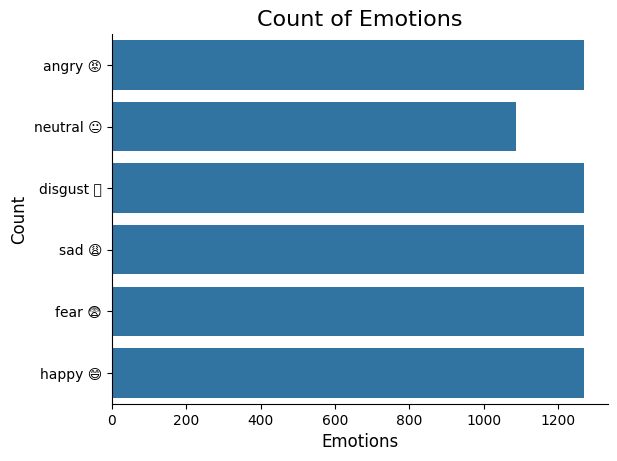

In [102]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [103]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

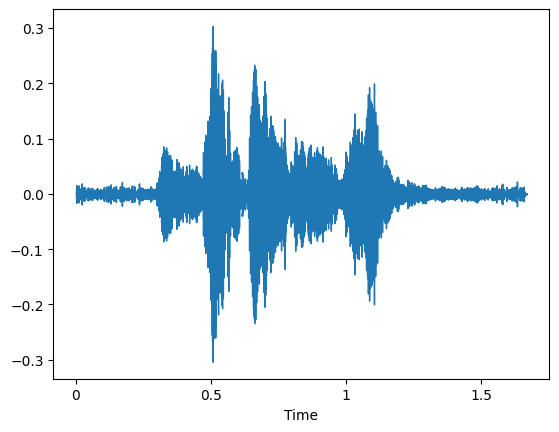

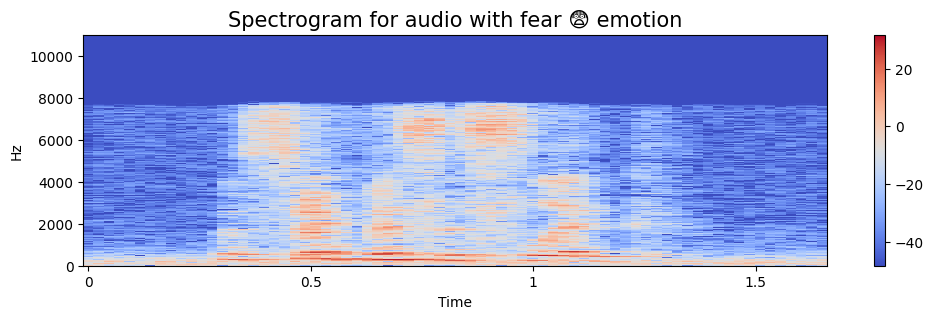

In [104]:
emotion='fear 😨'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

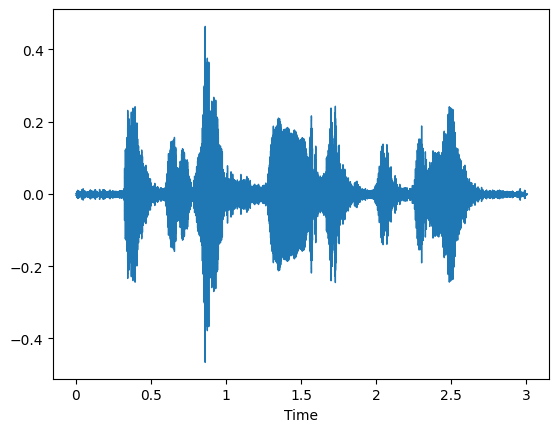

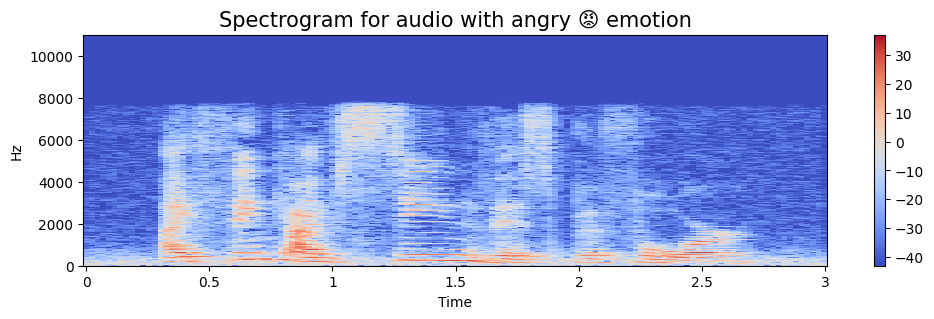

In [105]:
emotion='angry 😡'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

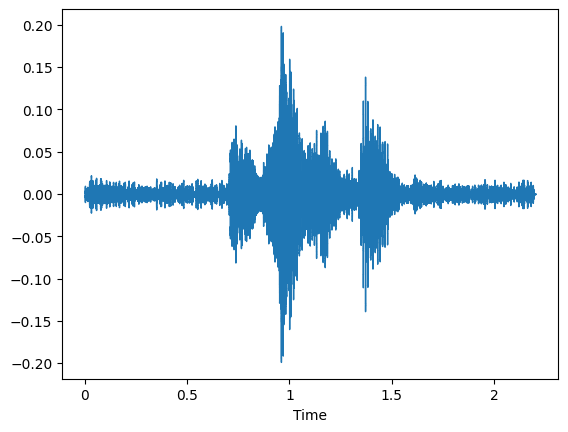

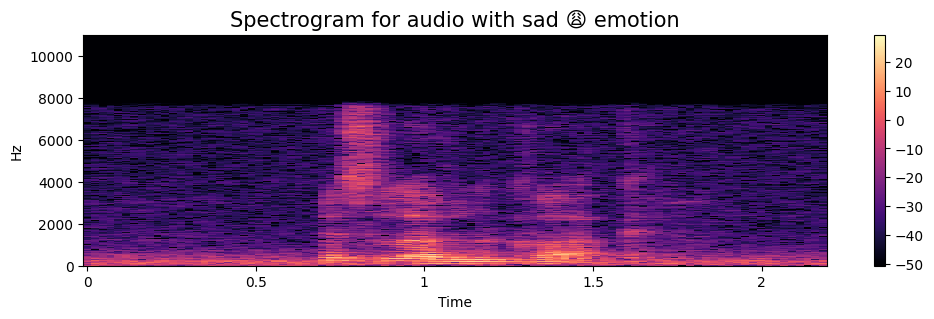

In [106]:
emotion='sad 😩'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

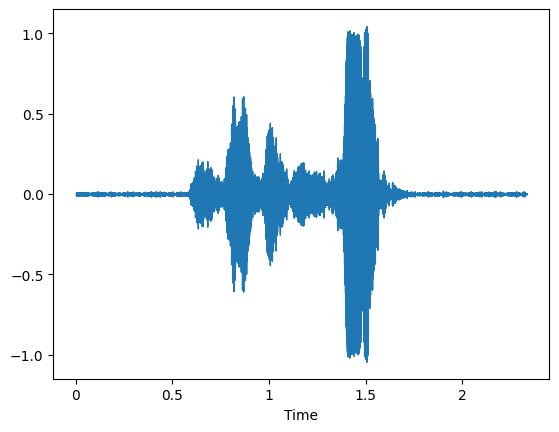

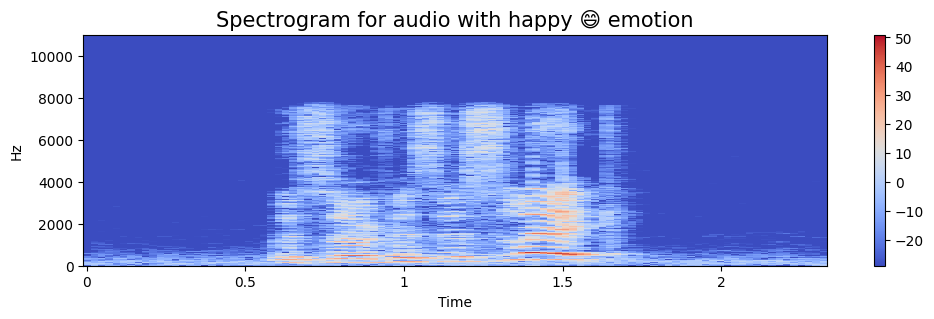

In [107]:
emotion='happy 😄'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation




In [108]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

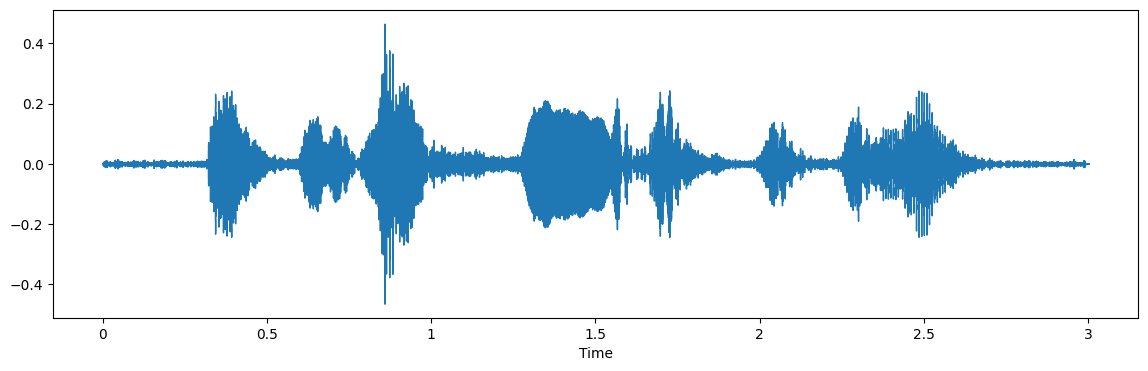

In [109]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(data)
Audio(path)

#### 2. Noise Injection

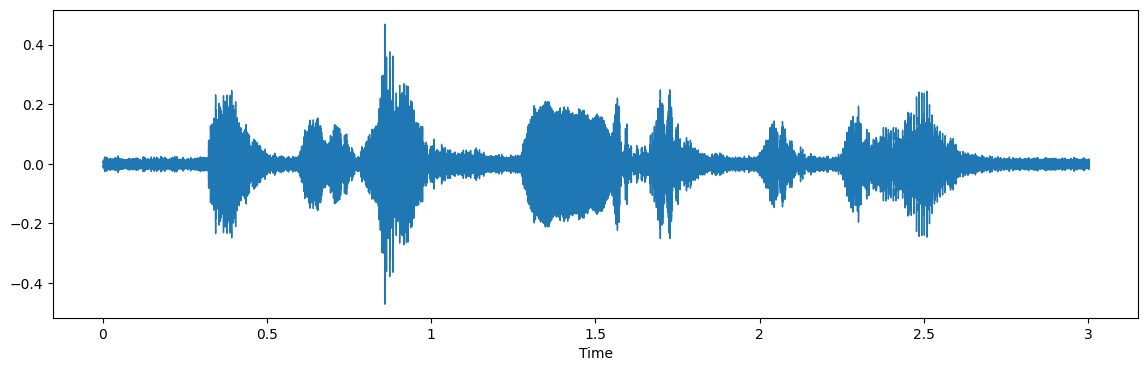

In [110]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(x)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

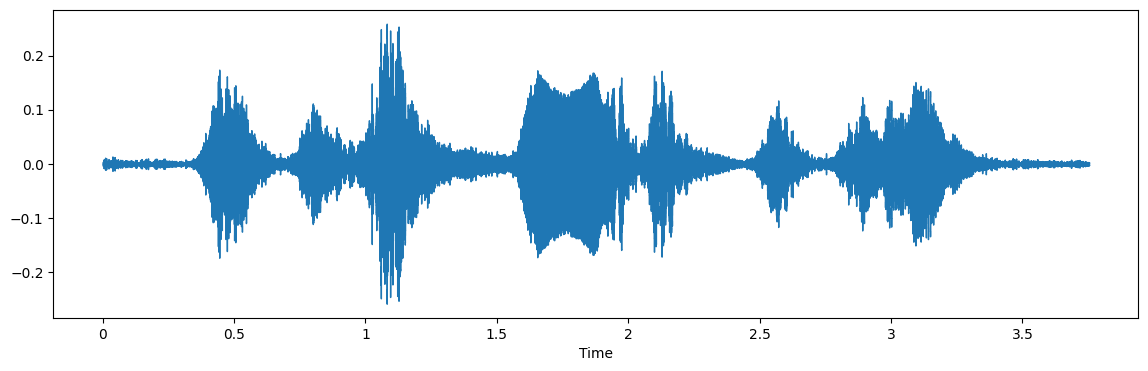

In [111]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(x)
Audio(x, rate=sample_rate)

#### 4. Shifting

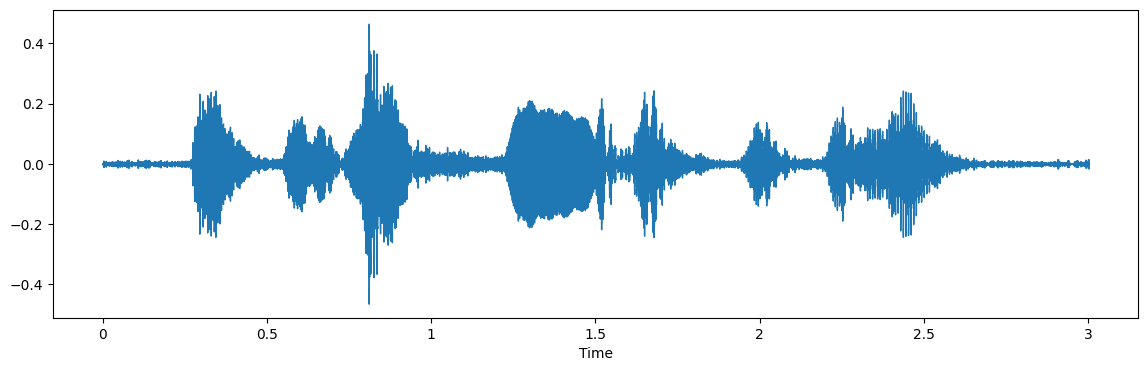

In [112]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(x)
Audio(x, rate=sample_rate)

#### 5. Pitch

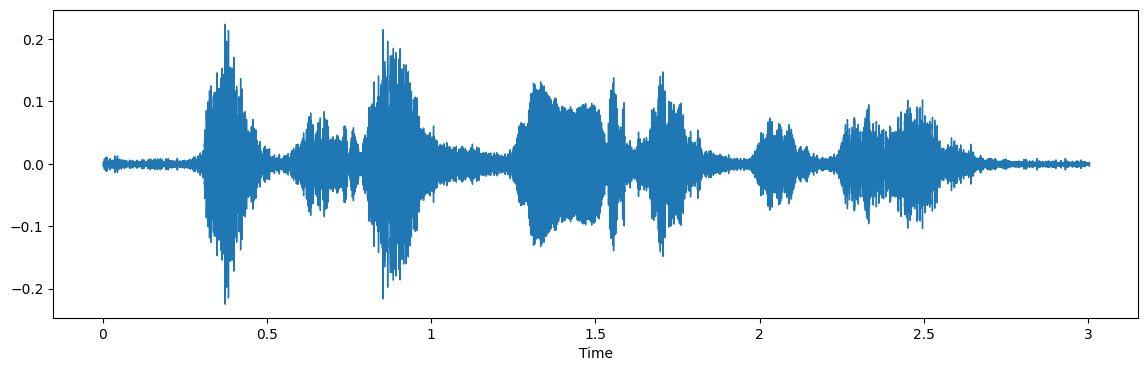

In [113]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(x)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction


In [114]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value 
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [117]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [118]:
len(X), len(Y), data_path.Path.shape

(22326, 22326, (7442,))

In [119]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.100586,0.595252,0.551953,0.520970,0.469345,0.523831,0.499308,0.522859,0.581303,0.584585,...,3.271244e-08,3.422796e-08,3.566387e-08,3.696841e-08,3.813799e-08,3.918522e-08,4.004809e-08,4.072273e-08,4.113186e-08,angry 😡
1,0.128900,0.645811,0.598756,0.573412,0.531883,0.582556,0.540828,0.552197,0.607131,0.601285,...,2.452432e-04,2.573970e-04,2.527708e-04,2.467645e-04,2.413952e-04,2.651449e-04,2.623512e-04,2.602886e-04,2.468133e-04,angry 😡
2,0.104364,0.497777,0.632946,0.569897,0.513045,0.442800,0.501157,0.466000,0.491438,0.574324,...,2.171902e-08,2.229597e-08,2.274603e-08,2.309255e-08,2.349755e-08,2.386798e-08,2.459561e-08,2.047917e-08,6.831495e-09,angry 😡
3,0.098154,0.591645,0.502407,0.504114,0.567158,0.523428,0.473053,0.553259,0.547363,0.501392,...,1.217806e-08,1.196992e-08,1.180550e-08,1.167072e-08,1.156799e-08,1.150221e-08,1.145568e-08,1.143314e-08,1.141620e-08,angry 😡
4,0.219755,0.724434,0.649843,0.650170,0.711391,0.652092,0.550063,0.591716,0.594161,0.549216,...,6.534915e-03,6.241951e-03,6.300843e-03,6.145145e-03,6.062891e-03,6.141635e-03,6.043962e-03,6.100883e-03,6.264236e-03,angry 😡


* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [120]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [121]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [122]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162), (16744, 6), (5582, 162), (5582, 6))

In [123]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162), (16744, 6), (5582, 162), (5582, 6))

In [124]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162, 1), (16744, 6), (5582, 162, 1), (5582, 6))

## Modelling

In [125]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,222 (2.13 MB)

 Trainable params: 557,222 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.2, verbose=0, patience=2, min_lr=0.00000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.2822 - loss: 1.6608 - val_accuracy: 0.3649 - val_loss: 1.5303 - learning_rate: 0.0010
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 55s 209ms/step - accuracy: 0.3566 - loss: 1.5363 - val_accuracy: 0.3796 - val_loss: 1.4873 - learning_rate: 0.0010
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.3591 - loss: 1.5195 - val_accuracy: 0.3785 - val_loss: 1.4689 - learning_rate: 0.0010
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 38s 147ms/step - accuracy: 0.3696 - loss: 1.5015 - val_accuracy: 0.3982 - val_loss: 1.4487 - learning_rate: 0.0010
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.3886 - loss: 1.4705 - val_accuracy: 0.4233 - val_loss: 1.4322 - learning_rate: 0.0010
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.3925 - loss: 1.4602 - val_accuracy: 0.4079 - val_loss: 1.4324 - learning_rate: 0.0010
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.4

In [127]:
# Save the model
# model.save('model-best-30.h5')
model.save('model-best-30.keras')

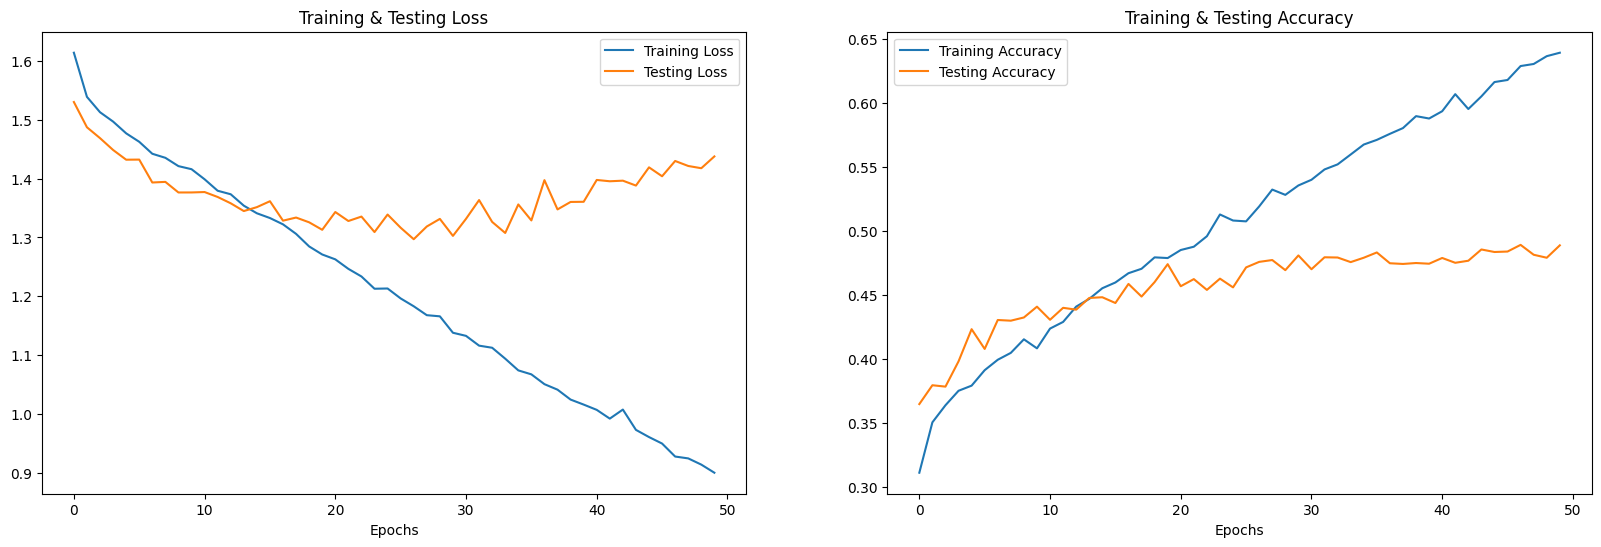

In [130]:
# print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [131]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [132]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad 😩,sad 😩
1,happy 😄,angry 😡
2,sad 😩,sad 😩
3,happy 😄,happy 😄
4,happy 😄,happy 😄
5,angry 😡,happy 😄
6,sad 😩,sad 😩
7,angry 😡,angry 😡
8,disgust 🤢,neutral 😐
9,sad 😩,fear 😨


In [133]:
# Count the number of correct predictions
correct_predictions = df['Predicted Labels'] == df['Actual Labels']
num_correct = correct_predictions.sum()

# Calculate the total number of predictions
total_predictions = len(df)

# Calculate accuracy
accuracy = num_correct / total_predictions

In [134]:
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 48.87%


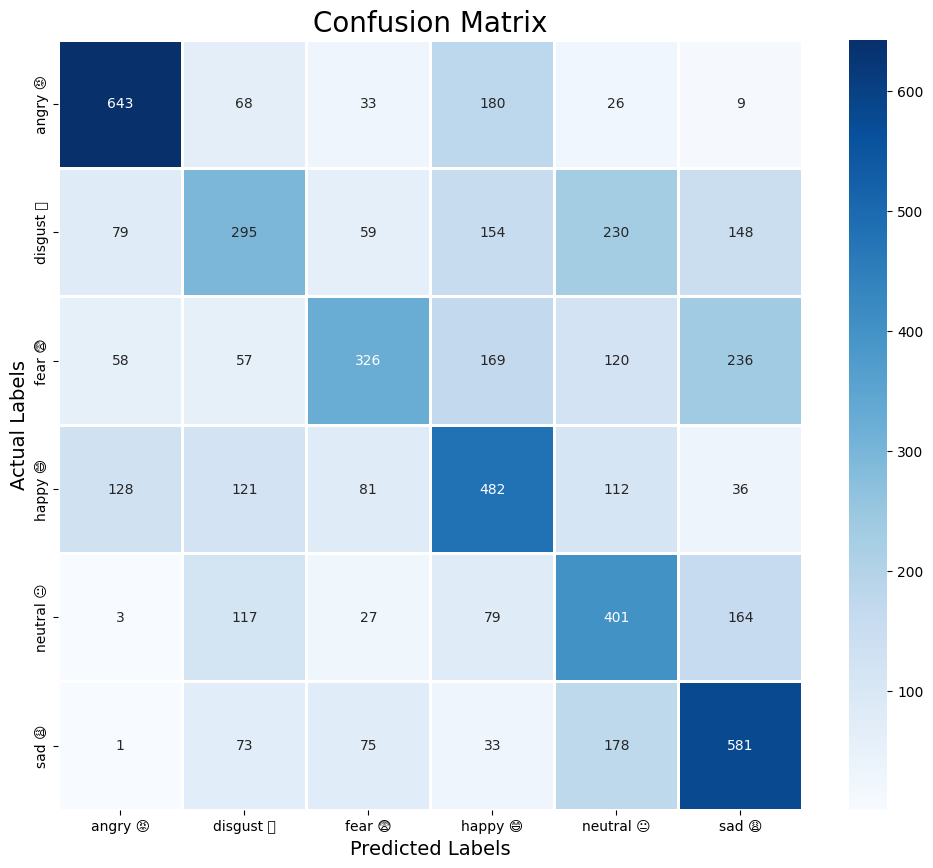

In [135]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     angry 😡       0.71      0.67      0.69       959
   disgust 🤢       0.40      0.31      0.35       965
      fear 😨       0.54      0.34      0.42       966
     happy 😄       0.44      0.50      0.47       960
   neutral 😐       0.38      0.51      0.43       791
       sad 😩       0.49      0.62      0.55       941

    accuracy                           0.49      5582
   macro avg       0.49      0.49      0.48      5582
weighted avg       0.50      0.49      0.48      5582

